# Graph Classification with the PROTEINS Dataset

Graph classification is the task of predicting an attribute or label of an entire graph. This is in contrast with node classification, for example, in which we are only interested in predicting the labels of the nodes in the graph. 

There are many possible applications of graph classification: determining the type of network a group of individuals forms (friendship group, work colleagues, family etc.), the classification of newly discovered molecules, determining the type of vehicle making a journey on a road network, and so on.

In this notebook we are going to employ graph classification to predict whether a protein is an enzyme or non-enzyme. Proteins can be represented as graphs, with the amino acids in the protein serving as the graph nodes, and the bonds between these amino acids as the graph edges. The dataset we are going to use is the PROTEINS dataset, which is a benchmark dataset for graph classification tasks. 

To perform graph classification we are going to utilise the StellarGraph Python library to construct and train a Deep Graph Convolutional Neural Network (DGCNN). StellarGraph offers a wide variety of state-of-the-art algorithms for graph Machine Learning, and is very intuitive to use. 

In [23]:
import numpy as np
import stellargraph as sg
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from stellargraph import datasets
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import confusion_matrix, classification_report

We begin by loading the PROTEINS dataset which is included in StellarGraph. 

In [24]:
dataset = datasets.PROTEINS()
print(dataset.description)

Each graph represents a protein and graph labels represent whether they are are enzymes or non-enzymes. The dataset includes 1113 graphs with 39 nodes and 73 edges on average for each graph. Graph nodes have 4 attributes (including a one-hot encoding of their label), and each graph is labelled as belonging to 1 of 2 classes.


In [25]:
graphs, labels = dataset.load()

Let's have a look at one of the protein graph objects in the dataset.

In [26]:
print(graphs[2].info())

StellarGraph: Undirected multigraph
 Nodes: 10, Edges: 34

 Node types:
  default: [10]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [34]
        Weights: all 1 (default)
        Features: none


This graph is a multigraph (two nodes may be connected by multiple edges) and has undirected edges. It has 10 nodes and 34 edges. The nodes have four features, as expected, and the edges have none. All edges are weighted equally.

Let's have a look at this graph's nodes.

In [27]:
graphs[2].nodes()

Int64Index([70, 71, 72, 73, 74, 75, 76, 77, 78, 79], dtype='int64')

Let's look at the edges that run between these nodes.

In [28]:
graphs[2].edges()

[(71, 70),
 (72, 70),
 (79, 70),
 (70, 71),
 (72, 71),
 (79, 71),
 (70, 72),
 (71, 72),
 (73, 72),
 (79, 72),
 (72, 73),
 (74, 73),
 (75, 73),
 (73, 74),
 (75, 74),
 (76, 74),
 (73, 75),
 (74, 75),
 (76, 75),
 (77, 75),
 (78, 75),
 (74, 76),
 (75, 76),
 (77, 76),
 (78, 76),
 (75, 77),
 (76, 77),
 (78, 77),
 (75, 78),
 (76, 78),
 (77, 78),
 (70, 79),
 (71, 79),
 (72, 79)]

We can get the degree of each graph node. For example,

In [29]:
graphs[2].node_degrees()

defaultdict(int,
            {70: 6,
             71: 6,
             72: 8,
             73: 6,
             74: 6,
             75: 10,
             76: 8,
             77: 6,
             78: 6,
             79: 6})

We can get the adjacent neighbours to a node.

In [30]:
graphs[2].neighbors(73)

[72, 75, 74, 72, 75, 74]

Now let's take a look at the labels of all the graphs.

In [31]:
print(labels)

1       1
2       1
3       1
4       1
5       1
       ..
1109    2
1110    2
1111    2
1112    2
1113    2
Name: label, Length: 1113, dtype: category
Categories (2, object): ['1', '2']


In [32]:
labels.value_counts().to_frame()

,label
1,663
2,450


As we can see, there are more samples of label 1 than label 2 (59.5% to 40.5%).

We are going to simplify by changing the labels to zeros and ones.

In [33]:
labels = pd.get_dummies(labels, drop_first=True)
print(labels)

      2
1     0
2     0
3     0
4     0
5     0
...  ..
1109  1
1110  1
1111  1
1112  1
1113  1

[1113 rows x 1 columns]


In [34]:
labels.value_counts().to_frame()

,0
2,
0,663
1,450


It is always a good idea to shuffle the data before using it in a Machine Learning model.

In [35]:
graphs, labels = shuffle(graphs, labels)

Now we are going to define some methods that will separate our graphs and labels into training, validation and testing sets.  

In [36]:
class DataPreprocessing:
    
    def __init__(self, graphs, labels):
        
        self.graphs = graphs
        self.labels = labels
        

    def training_testing_sets(self, test_size):
        
        # splits the data into training and testing sets
        train_graphs, test_graphs, train_labels, test_labels = train_test_split(self.graphs, self.labels, 
                                                                                test_size = test_size, random_state = 3)
        return train_graphs, test_graphs, train_labels, test_labels

    
    @staticmethod
    def train_valid_sets(train_graphs, train_labels, validation_size):
        
        # create a validation set from the training set
        training_size = int((1-validation_size)*1000)
        validation_size = int(1000*validation_size)
        # for later use in generators we only require the split indices and not the splits themselves
        train_index = [i for i in range(training_size)]
        valid_index = [i for i in range(training_size, training_size+validation_size+1)]
        # get the corresponding labels
        train_labels1 = train_labels[:training_size]
        valid_labels = train_labels[training_size:]
        return train_index, valid_index, train_labels1, valid_labels

Let's perform the split.

In [37]:
data_preprocessing = DataPreprocessing(graphs, labels)
train_graphs, test_graphs, train_labels_0, test_labels = data_preprocessing.training_testing_sets(0.1)
train_index, valid_index, train_labels, valid_labels = data_preprocessing.train_valid_sets(train_graphs, train_labels_0, 
                                                                                     validation_size = 0.1)

The DGCNN model we are going to implement for graph classification is adapted from the paper "An End-to-End Deep Learning Architecture for Graph Classification" by Zhang, M., et al, 2018. The DGCNN model arised from the desire of the authors to improve the performance of spatial graph convolutional neural networks for graph classification. Previous attempts were disappointing; one reason was that much of a graph's rich node information was summend up into graph-level features. Their new model attempted to rectify this by retaining more of a graph's node information and learning from its topology. The first layers of the DGCNN are the spatial graph convolution layers, defined by

$$Z = \sigma\left(\bar{D^{-1}}\bar{A}XW\right)\tag*{(1)}$$

where $\sigma$ is a non-linear activation function, $\bar{A} = A + I$ is the adjacency matrix of the graph with added self-loops (self-loops appear as the diagonal elements in an adjacency matrix), $\bar{D}$ is the degree matrix corresponding to $\bar{A}$, $X$ is the graph's node information matrix (each row consists of a node's feature vector), and $W$ is a weights matrix. Let's use an example with some $3\times3$ matrices to see how the convolution works: 

$$\begin{align}\bar{A}XW &= \begin{pmatrix}
1 & a_{12} & a_{13}\\
a_{21} & 1 & a_{23}\\
a_{31} & a_{32} & 1
\end{pmatrix}
\begin{pmatrix}
x_{11} & x_{12} & x_{13}\\
x_{21} & x_{22} & x_{23}\\
x_{31} & x_{32} & x_{33}
\end{pmatrix}
\begin{pmatrix}
w_{11} & w_{12} & w_{13}\\
w_{21} & w_{22} & w_{23}\\
w_{31} & w_{32} & w_{33}
\end{pmatrix}\\
&= \begin{pmatrix}
1 & a_{12} & a_{13}\\
a_{21} & 1 & a_{23}\\
a_{31} & a_{32} & 1
\end{pmatrix}
\begin{pmatrix}
x_{11}w_{11}+x_{12}w_{21}+x_{13}w_{31} & x_{11}w_{12}+x_{12}w_{22}+x_{13}w_{32} & x_{11}w_{13}+x_{12}w_{23}+x_{13}w_{33}\\
x_{21}w_{11}+x_{22}w_{21}+x_{23}w_{31} & x_{21}w_{12}+x_{22}w_{22}+x_{23}w_{32} & x_{21}w_{13}+x_{22}w_{23}+x_{23}w_{33}\\
x_{31}w_{11}+x_{32}w_{21}+x_{33}w_{31} & x_{31}w_{12}+x_{32}w_{22}+x_{33}w_{32} & x_{31}w_{13}+x_{32}w_{23}+x_{33}w_{33}
\end{pmatrix}
\end{align}
$$

If we look at, say $(\bar{A}XW)_{11}$, the first element of the first row of $\bar{A}XW$, we will have the matrix element

$$
x_{11}w_{11}+x_{12}w_{21}+x_{13}w_{31} + a_{12}(x_{21}w_{11}+x_{22}w_{21}+x_{23}w_{31}) + a_{13}(x_{31}w_{11}+x_{32}w_{21}+x_{33}w_{31})
$$

This is just 
$$(XW)_{11}+a_{12}(XW)_{21}+a_{13}(XW)_{31}\tag*{(2)}$$

Therefore, $XW$ represents a linear transformation of the node information matrix, and $\bar{A}XW$ propagates a node's information to its neighbours, and not just itself. Information is only propagated to a node's neighbours since in the adjacency matrix $\bar{A}$, elements are zero between nodes that are not adjacent.

Next comes the multiplication by $\bar{D^{-1}}$ which normalises each row of $\bar{A}XW$ to keep a fixed feature scale after convolution. We can see how this works with a simple example using $2\times2$ matrices:

Let's say that we have $\bar{A} = \begin{pmatrix}
1 & a_{12}\\
a_{21} & 1
\end{pmatrix}$

This would mean that 

$$\bar{D} = \begin{pmatrix}
1+a_{12} & 0\\
0 & 1+a_{21}
\end{pmatrix}$$ and $$\bar{D^{-1}} = \frac{1}{(1+a_{21})(1+a_{12})}\begin{pmatrix}
1+a_{21} & 0\\
0 & 1+a_{12}
\end{pmatrix}$$

Multiplying $\bar{D^{-1}}$ and $\bar{A}$ together we get

$$\begin{align}\bar{D^{-1}}\bar{A} &= \frac{1}{(1+a_{21})(1+a_{12})}\begin{pmatrix}
1+a_{21} & 0\\
0 & 1+a_{12}
\end{pmatrix}\begin{pmatrix}
1 & a_{12}\\
a_{21} & 1
\end{pmatrix}\\
&= \begin{pmatrix}
\frac{1}{1+a_{12}} & \frac{a_{12}}{1+a_{12}}\\
\frac{a_{21}}{1+a_{21}} & \frac{1}{1+a_{21}}
\end{pmatrix}\end{align}$$

Adding the first row's elements we get 
$$\frac{1}{1+a_{12}} + \frac{a_{12}}{1+a_{12}} = \frac{1+a_{12}}{1+a_{12}} = 1$$

Adding the second row's elements we get
$$\frac{a_{21}}{1+a_{21}} + \frac{1}{1+a_{21}} = \frac{1+a_{21}}{1+a_{21}} = 1$$

i.e., the rows are normalised to unity. 

A single graph convolution layer aggregates node information in local neighbourhoods to extract local substructure information. To extract multi-scale substructure features we must stack multiple graph convolution layers according to 

$$Z^{n+1} = \sigma\left(\bar{D^{-1}}\bar{A}Z^nW^n\right)$$

where $Z^n$ is the output of the nth graph convolution layer ($Z^0 = X$), and $W^n$ is the weights matrix for the nth layer.

After the convolution layers, all the outputs, the $Z^i$, are concatenated together horizontally to form a new matrix $Z^{1:p}$, where $p$ is the number of convolution layers. Each row of $Z^{1:p}$ will consist of the output computed for the same node in each of the convolution layers. For example, if we have three convolution layers and the rows for, say, node A in each layer are $(z^1_{A})$, $(z^2_{A})$, and $(z^3_{A})$ respectively, then the row for node A in $Z^{1:3}$ will be $(z^1_{A}\quad z^2_{A}\quad z^3_{A})$. The rows of $Z^{1:p}$ are called the feature descriptors.

After the graph convolution layers comes the sort-pooling layer. The main function of this layer is to sort the node feature descriptors in a consistent manner before passing them on to the conventional convolutional and fully-connected layers. The sort-pooling layer is able to do this since the output of the final graph convolution layer is the same as that of the Weisfeiler-Lehman (WL) algorithm. 

The WL algorithm is typically employed to determine if two graphs are isomorphic. It's first step is to give all the graph nodes the same label, or colour. A node is then assigned a tuple which is comprised of two parts: the node's colour, and a multiset (a set which allows multiple instances of the same element) of the colours of the node's one-hop neighbours. New colours are assigned again, with any nodes sharing identical tuples taking the same colour. This process is repeated again and again until the colours converge or some maximum iteration is reached. For a better description see [here](https://davidbieber.com/post/2019-05-10-weisfeiler-lehman-isomorphism-test/). Since the algorithm utilises only the structure of the graph, nodes that finish with the same colour will have the same structural role in the graph.

We can see from equations (1) and (2) that the i-th row of $Z$ can be expressed as
$$Z_{i} = \sigma\Biggl\{\bar{D^{-1}}_{ii}\left[(XW)_{i} + \sum_{j} (XW)_{j}\right]\Biggr\}$$
where the $j$ represent the nodes adjacent to node $i$.

The portion within the curly brackets is analogous to the tuple label in the WL algorithm, since it is aggregating the feature information of node i and its neighbours (In the WL algorithm, node i's colour is aggregated with those of its neighbours). The non-linear function $\sigma$ then effectively maps this aggregated feature information to a new colour.

The input to the sort-pooling layer, $Z^{1:p}$, is first sorted according to $Z^{p}$, the final output layer, since the colours in this layer can be considered the most refined. Nodes (rows) are sorted in descending order according to the final column of $Z^{p}$. If there exists a tie between two or more nodes, the second to last columns are compared, and so on. If the ties continue, the columns are then compared in $Z^{p-1}$, $Z^{p-2}$, and so on. In this way, graph nodes are consistently ordered, permitting the training of traditional neural networks on the representations.

Another caracteristic of the sort-pooling layer is that it standardises, to an integer $k$, the number of rows in the output $Z^{p}$. Rows can be added or deleted, depending on whether the output has less or more rows than $k$, respectively. This enables the model to be trained on graphs consisting of varying numbers of nodes. Furthermore, the sort-pooling layer is able to pass loss function gradients back to the previous layers by remembering the sorted order of its input. Therefore, the parameters of these layers can be trained and backpropagation undertaken. 

The final output from the sort-pooling layer is reshaped into a $k\sum_{1}^{p}c_n \times 1$ vector, where $c_n$ is the number of feature channels (columns) of layer $n$. For example, if we have three layers and $c_{1} = 6$, $c_{1} = 5$, $c_{1} = 4$, and we choose $k = 10$, the reshaped output will be a $(150 \times 1)$ vector. The first 1D-convolutional layer is chosen to have a filter size and stride length of $\sum_{1}^{p}c_n$. The consequence of this is that filters are applied sequentially on vertices' feature descriptors. Returning to our example, a filter is first applied to the 15 feature descriptors (six in the first layer, five in the second, four in the thrid) of node one (for lack of a better naming convention), then to the 15 feature descriptors of node two, and so on, until the filter has been applied to all $k=10$ nodes. A max-pooling layer and another 1D-convolutional layer are then employed to learn local patterns on the node sequence. These are followed by several fully-connected layers.

Now we are going to create our DGCNN model using StellarGraph and Keras. Initially, we require generator methods that will pass the data into the model in batches. The first layers in the DGCNN are the graph convolutional layers. Following these are a sort-pooling layer and a standard convolutional layer. Next comes a max-pooling layer, followed by another convolutional layer. The output is flattened and passed through three fully-connected layers, with the last being the output layer. The model is then layered together and configured; we choose the Adam optimisation algorithm and an appropriate cost function. There are also methods that will employ the DGCNN to make predictions on the testing set and evaluate the model's performance. 

In [38]:
class DGCNN:
    
    
    @staticmethod
    def create_generator(graphs):
        
        # PaddedGraphGenerator supplies the features arrays and the adjacency matrices to a mini-batch Keras
        # graph classification model.
        generator = PaddedGraphGenerator(graphs=graphs)
        return generator


    def get_training_generators(self, train_graphs, train_index, train_labels, valid_index, valid_labels, batch_size):
        
        # create generator of training data
        self.training_generator = self.create_generator(train_graphs)
        # flow reates a generator/sequence object for training, evaluation, or prediction
        # with the supplied graph indexes and targets.
        # generate generator flow objects for training and validation data.
        self.train_gen = self.training_generator.flow(train_index, targets = train_labels, 
                                                              batch_size = batch_size)
        self.valid_gen = self.training_generator.flow(valid_index, targets = valid_labels, 
                                                              batch_size = batch_size)



    def get_testing_generator(self, test_graphs, test_labels):
        
        # create generator of testing data
        testing_generator = self.create_generator(test_graphs)
        # create generator flow object
        self.test_gen = testing_generator.flow(test_graphs, targets = test_labels, batch_size =1, 
                                               symmetric_normalization = False)
        

    def create_DGCNN(self, layer_sizes, activations, k, num_kernels, kernel_sizes, strides, 
              pool_size, num_neurons, fc_activations):
        
        # add a stack of graph convolution layers with a sort-pooling layer
        dgcnn = DeepGraphCNN(layer_sizes = layer_sizes, activations = activations, k = k, bias = False, 
                             generator = self.training_generator)
        # access the input and output tensors of the graph convolution layers
        x_inp, x_out = dgcnn.in_out_tensors()
        # first conventional convolutional layer
        output1 = Conv1D(filters = num_kernels[0], kernel_size = kernel_sizes[0], strides = strides[0])(x_out)
        # max-pooling layer
        output2 = MaxPool1D(pool_size = pool_size)(output1)
        # second conventional convolutional layer
        output3 = Conv1D(filters = num_kernels[1], kernel_size = kernel_sizes[1], strides = strides[1])(output2)
        # flatten output for dense layers
        output4 = Flatten()(output3)
        # first dense layer
        output5 = Dense(units = num_neurons[0], activation = fc_activations[0])(output4)
        # second dense layer
        output7 = Dense(units = num_neurons[1], activation = fc_activations[1])(output4)
        # output layer
        predictions = Dense(units = 1, activation = fc_activations[2])(output7)
        # group all layers into model object
        self.model = Model(inputs = x_inp, outputs = predictions)



    def configure_train_DGCNN(self, learning_rate, loss_function, epochs):
        
        # configure model
        self.model.compile(optimizer = Adam(learning_rate = learning_rate), loss = loss_function, metrics = ['acc'])
        # train model with training and validation sets
        self.history = self.model.fit(self.train_gen, epochs = epochs, verbose = 1, validation_data = self.valid_gen,
                                 shuffle = False)
        

 
    @staticmethod        
    def get_prediction_assessment(row):
        
        # this function indicates whether a prediction is a true-positive, true-negative, false-positive,
        # or false-negative
    
        prediction = row['prediction']
        label = row['label']
        if prediction > 0.5 and label == 1:
            return 'TP'
        elif prediction < 0.5 and label == 1:
            return 'FN'
        elif prediction > 0.5 and label == 0:
            return 'FP'
        else:
            return 'TN'
        
    
    def get_test_results(self):
           
        # get predictions on the test set
        predictions = self.model.predict(self.test_gen)
        # convert to list
        predictions2 = [i[0] for i in predictions]
        # create dataframe of the results
        results_dict = {'prediction': predictions2, 'label': test_labels['2'].tolist()}
        self.results_df = pd.DataFrame(data=results_dict)
        self.results_df['assessment'] = self.results_df.apply(lambda row: self.get_prediction_assessment(row), axis = 1)
        
   
    def evaluate_results(self):
        
        # get class labels for the model's predicted probabilities 
        self.predicted_classes = np.where(self.results_df['prediction'] > 0.5, 1, 0)
        # generate confusion matrix and classification report
        self.confusion_matrix = confusion_matrix(self.results_df['label'], self.predicted_classes)
        self.classification_report = classification_report(self.results_df['label'], self.predicted_classes)
        
    
    def training_history(self):
        
        # produce plots of loss and metric history
        sg.utils.plot_history(self.history)        

The argument layer_sizes of the create_DGCNN method refers to the number of columns in the output of the graph convolution layers, i.e., the number of columns in the $Z^p$. We will use the same number of graph convolution layers, with the same number of output columns as Zhang et al, i.e., four convolution layers with the first three having 32 output columns and the last having one, with this single column being the only one utilised for sorting the nodes, out of convenience. The numbers of kernels used in the 1D-convolutional layers follows those used by Zhang et al, as do the activation functions used in the graph convolution and fully-connected layers. Unlike Zhang et al, we do not use a dropout layer, since performance on the test set was improved wihtout one. Performance on the test set deteriorated for larger learning rates, so this was kept very small. Since our problem is a binary classification task, the cross-entropy cost function was employed.

In [39]:
# instantiate DGCNN object
dgcnn = DGCNN()
# create the data generators used in model training and specify a training batch size of 25
dgcnn.get_training_generators(train_graphs, train_index, train_labels, valid_index, valid_labels, 25)
# create the DGCNN model, specifying all layer parameters
dgcnn.create_DGCNN(layer_sizes = [32, 32, 32, 1], activations = ['tanh', 'tanh', 'tanh', 'tanh'], k = 35, 
                   num_kernels = [16, 32], kernel_sizes = [sum([32, 32, 32, 1]), 4], strides = [sum([32, 32, 32, 1]), 1],
                   pool_size = 2, num_neurons = [32, 32], fc_activations = ['relu', 'relu', 'sigmoid'])
# compile and train the DGCNN
dgcnn.configure_train_DGCNN(learning_rate = 0.0001, loss_function = 'binary_crossentropy', epochs = 100)
# create the data generator used in testing
dgcnn.get_testing_generator(test_graphs, test_labels)

Epoch 1/100
36/36 [==============================] - 8s 115ms/step - loss: 0.6387 - acc: 0.6144 - val_loss: 0.5763 - val_acc: 0.6931
Epoch 2/100
36/36 [==============================] - 4s 100ms/step - loss: 0.6156 - acc: 0.6767 - val_loss: 0.5704 - val_acc: 0.7723
Epoch 3/100
36/36 [==============================] - 3s 81ms/step - loss: 0.6040 - acc: 0.7011 - val_loss: 0.5682 - val_acc: 0.7624
Epoch 4/100
36/36 [==============================] - 3s 86ms/step - loss: 0.5966 - acc: 0.7189 - val_loss: 0.5647 - val_acc: 0.7723
Epoch 5/100
36/36 [==============================] - 3s 89ms/step - loss: 0.5914 - acc: 0.7178 - val_loss: 0.5607 - val_acc: 0.7723
Epoch 6/100
36/36 [==============================] - 3s 91ms/step - loss: 0.5873 - acc: 0.7178 - val_loss: 0.5558 - val_acc: 0.7723
Epoch 7/100
36/36 [==============================] - 3s 89ms/step - loss: 0.5840 - acc: 0.7178 - val_loss: 0.5518 - val_acc: 0.7723
Epoch 8/100
36/36 [==============================] - 3s 85ms/step - loss: 

36/36 [==============================] - 3s 86ms/step - loss: 0.5231 - acc: 0.7589 - val_loss: 0.5111 - val_acc: 0.7525
Epoch 63/100
36/36 [==============================] - 3s 86ms/step - loss: 0.5232 - acc: 0.7611 - val_loss: 0.5121 - val_acc: 0.7525
Epoch 64/100
36/36 [==============================] - 3s 87ms/step - loss: 0.5224 - acc: 0.7600 - val_loss: 0.5126 - val_acc: 0.7525
Epoch 65/100
36/36 [==============================] - 3s 86ms/step - loss: 0.5221 - acc: 0.7589 - val_loss: 0.5118 - val_acc: 0.7525
Epoch 66/100
36/36 [==============================] - 3s 88ms/step - loss: 0.5216 - acc: 0.7589 - val_loss: 0.5129 - val_acc: 0.7525
Epoch 67/100
36/36 [==============================] - 3s 88ms/step - loss: 0.5212 - acc: 0.7578 - val_loss: 0.5129 - val_acc: 0.7525
Epoch 68/100
36/36 [==============================] - 3s 85ms/step - loss: 0.5209 - acc: 0.7578 - val_loss: 0.5145 - val_acc: 0.7525
Epoch 69/100
36/36 [==============================] - 3s 88ms/step - loss: 0.5205 

We can view the model's predictions on the test set.

In [40]:
dgcnn.get_test_results()
dgcnn.results_df[0:21]

,prediction,label,assessment
0,0.122540,0,TN
1,0.111393,1,FN
2,0.403089,1,FN
3,0.429360,0,TN
4,0.105703,0,TN
5,0.829533,1,TP
6,0.193982,0,TN
7,0.206989,0,TN
8,0.846747,1,TP
9,0.699649,1,TP


Now let's view the numpy array of predicted classes. Verify with the 'prediction' column of the above dataframe. These predicted labels are required to generate the confusion matrix and classification report.

In [41]:
dgcnn.evaluate_results()
print(dgcnn.predicted_classes)

[0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1
 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1
 1]


Precision is defined as 
$$P = \frac{|TP|}{|TP| + |FP|}$$
and recall as
$$R = \frac{|TP|}{|TP| + |FN|}$$
where $|TP|$ is the number of true-positives, $|FP|$ is the number of false-positives, and $|FN|$ is the number of false-negatives. Precision essentially tells us the proportion of positive predictions that are actually correct, whereas the recall gives us the proportion of positive samples that are correctly predicted. A good classifier therefore, will have precision and recall close to one.

Let's view some of the predictions made by the DGCNN model. Note that the above equations are defined for the positive class only, but we can in fact calculate the precision and recall for the negative class by switching the labels around, i.e., switching true-negatives for true-positives, and false-positives for false-negatives. 

In [42]:
print(dgcnn.confusion_matrix)
print(dgcnn.classification_report)

[[54 11]
 [15 32]]
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        65
           1       0.74      0.68      0.71        47

    accuracy                           0.77       112
   macro avg       0.76      0.76      0.76       112
weighted avg       0.77      0.77      0.77       112



We can see that performance on the positive class is worse than on the negative class. This is likely due to the class imabalance that exists between the two labels. 

Let's finish off by visualising the training history of the DGCNN model.

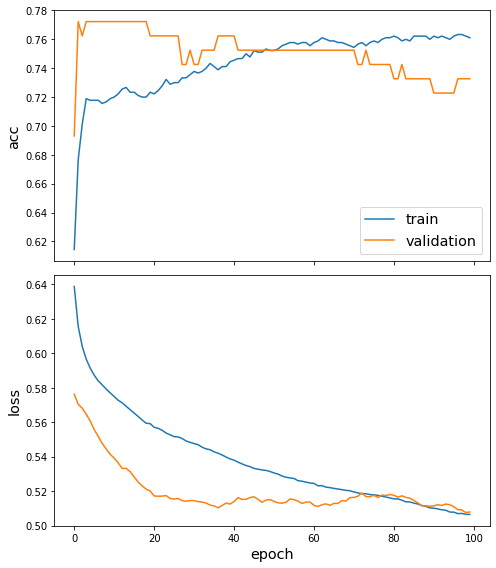

In [43]:
dgcnn.training_history()